# Fake News Detection

## **Tujuan**

Dampak yang ditimbulkan adanya berita hoax akan sangat luar biasa antara lain, berupa dampak sosial,ekonomi, politik, keamanan dan yang lebih besar adalah bisa mengancam keutuhan negara. Penyebaran berita hoax sering terjadi di media sosial dan mempengaruhi pola pikir masyarakat.

*Fake news is a modern problem which requires modern solutions.*

## **Dataset**
Sumber dataset : https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

## **Import**

In [46]:
import pandas as pd

#Visualisasi
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from string import punctuation
import spacy
import matplotlib
import seaborn as sns

#Preprocessing
from nltk.corpus import stopwords
import nltk
import regex as re

#Modelling
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import warnings

#Evaluasi
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')

## **Load & EDA**

In [4]:
trueNews = pd.read_csv("Datasets/True.csv")
fakeNews = pd.read_csv("Datasets/Fake.csv")

#Berikan label untuk tiap data
trueNews['label'] = 1
fakeNews['label'] = 0

df = pd.concat([fakeNews, trueNews], axis =0) #Gabungkan data

df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


### Shape tiap data

In [3]:
print(f'Dimensi data Fake-News : {fakeNews.shape}')
print(f'Dimensi data True-News : {trueNews.shape}')
print(f'Dimensi data Gabungan  : {df.shape}')

Dimensi data Fake-News : (23481, 5)
Dimensi data True-News : (21417, 5)
Dimensi data Gabungan  : (44898, 5)


### Inspect kolom

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


### Inspect data kategorikal

In [5]:
cat = ['subject','label']

for i in cat:
    print(df[i].value_counts())
    print("")

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

0    23481
1    21417
Name: label, dtype: int64



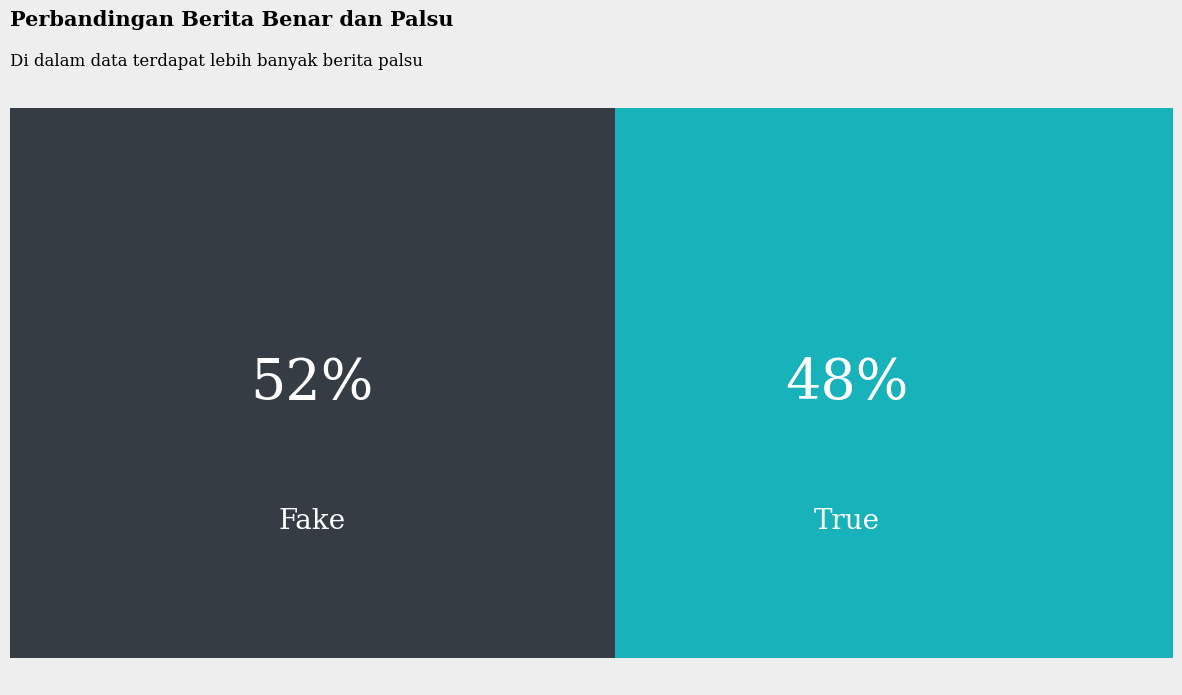

In [6]:
x = df.groupby('label')['label'].count()
y = len(df)


r=((x/y)).round(2)
status_ratio = pd.DataFrame(r).T
status_ratio.columns = ["Fake", "True"]

fig, ax = plt.subplots(1,1,figsize=(15, 8),dpi = 100)

fig.patch.set_facecolor('#EEEEEE')

ax.set_facecolor('#EEEEEE')

ax.barh(status_ratio.index, status_ratio['Fake'], 
        color='#222831', alpha=0.9, label='Fake')
ax.barh(status_ratio.index, status_ratio['True'], left=status_ratio['Fake'], 
        color='#00ADB5', alpha=0.9, label='True')


for i in status_ratio.index:
    ax.annotate(f"{int(status_ratio['Fake'][i]*100)}%", 
                   xy=(status_ratio['Fake'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')

    ax.annotate("Fake", 
                   xy=(status_ratio['Fake'][i]/2, -0.20),
                   va = 'center', ha='center',fontsize=20, fontweight='light', fontfamily='serif',color='white')

for i in status_ratio.index:
    ax.annotate(f"{int(status_ratio['True'][i]*100)}%", 
                   xy=(status_ratio['True'][i]+status_ratio['True'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')
    ax.annotate("True", 
                   xy=(status_ratio['True'][i]+status_ratio['True'][i]/2, -0.20),
                   va = 'center', ha='center',fontsize=20, fontweight='light', fontfamily='serif',
                   color='white')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])

# Title & Subtitle
fig.text(0.125,0.95,'Perbandingan Berita Benar dan Palsu', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(0.125,0.90,'Di dalam data terdapat lebih banyak berita palsu',fontfamily='serif',fontsize=12)  

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

### Check Null Value

In [7]:
df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

Tidak terdapat nilai *null* didalam data

### Wordclouds

In [8]:
TrueWords = trueNews['text'].tolist()
FalseWords = fakeNews['text'].tolist()

#Hilangkan stopwords
stopwords = set(stopwords.words('english'))
TrueWords = [word for word in TrueWords if not word in stopwords]
FalseWords = [word for word in FalseWords if not word in stopwords]

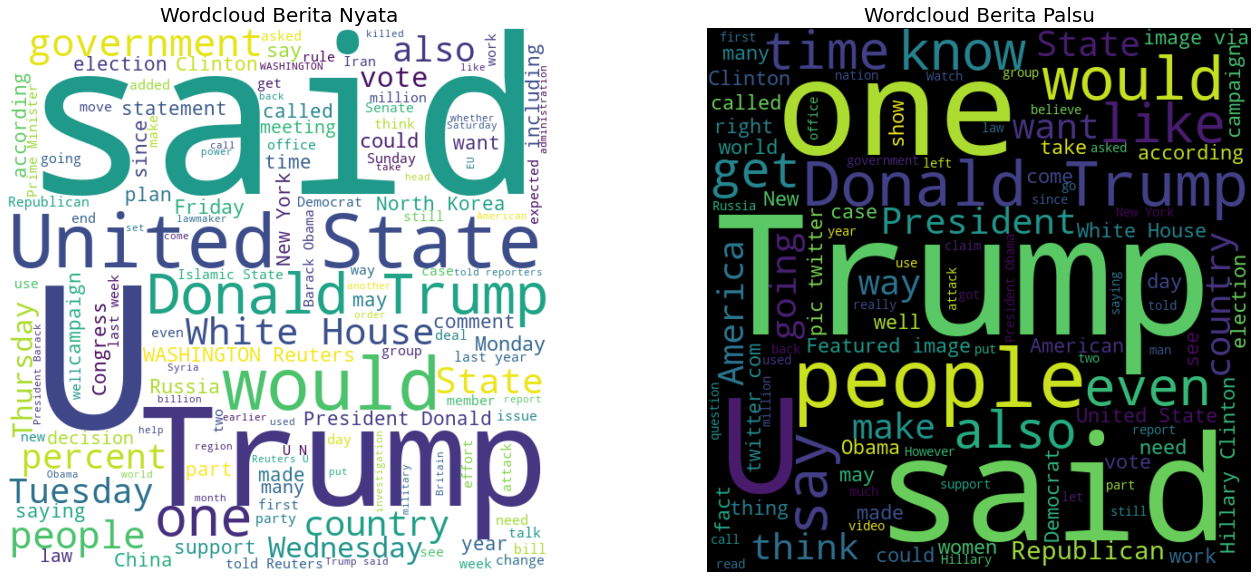

In [9]:
#buat word cloud
Truewordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(str(TrueWords))


Falsewordcloud = WordCloud(width = 600, height = 600, 
                stopwords = stopwords,
                max_words=100,
                min_font_size = 10).generate(str(FalseWords))  
  

#Plot wordcloud             
plt.figure(figsize = (23, 10), facecolor = None)

#Wordcloud Berita Nyata
plt.subplot(1,2,1)
plt.title("Wordcloud Berita Nyata",fontsize=20)
plt.imshow(Truewordcloud, interpolation='bilinear') 
plt.axis("off") 

#Wordcloud Berita Palsu
plt.subplot(1,2,2)
plt.title("Wordcloud Berita Palsu",fontsize=20)
plt.imshow(Falsewordcloud, interpolation='bilinear') 
plt.axis("off") 
  
plt.show()

Dapat dilihat bahwa baik berita palsu atau asli didominasi dengan jenis berita yang berbau politik

### Counter with bag-of-words

In [12]:
nlp = spacy.load('en_core_web_sm')

In [14]:
word_counter_true = Counter()
word_counter_false = Counter()

for row in trueNews['text']:
    doc = nlp(row)
    # Hapus stopword dan kata hubung
    words = [token.text for token in doc if not token.is_stop and not token.is_punct and len(token.text) > 1]

    entities = [ent.text for ent in doc.ents if not ent.text.isspace() or ent.text != ' ' or ent.text != '  ']

    word_counter_true.update(words + entities)


for row in fakeNews['text']:
    doc = nlp(row)
    # Hapus stopword dan kata hubung
    words = [token.text for token in doc if not token.is_stop and not token.is_punct and len(token.text) > 1]

    entities = [ent.text for ent in doc.ents if not ent.text.isspace() or ent.text != ' ' or ent.text != '  ']

    word_counter_false.update(words + entities)

In [27]:
print("Top 10 - Kata yang paling sering muncul didalam berita asli")
for i,(word,num) in enumerate(word_counter_true.most_common(10)):
    print(f'{i+1}. {word} => {num}')


print("\nTop 10 - Kata yang paling sering muncul didalam berita Palsu")
for i,(word,num) in enumerate(word_counter_false.most_common(10)):
    print(f'{i+1}. {word} => {num}')


Top 10 - Kata yang paling sering muncul didalam berita asli
1. said => 99043
2. Trump => 85634
3. U.S. => 70164
4. Reuters => 57041
5. Republican => 31108
6. House => 18898
7. President => 18574
8. government => 18144
9. China => 16710
10. Tuesday => 16271

Top 10 - Kata yang paling sering muncul didalam berita Palsu
1. Trump => 127776
2. said => 33604
3. Obama => 32940
4.    => 32170
5. Clinton => 27720
6. people => 25216
7. Hillary => 20044
8. America => 19874
9. American => 19323
10. Donald => 18736


## **Preprocessing**

### Lower-Case Text

Ubah semua kata didalam text menjadi huruf kecil

In [5]:
#Check apakah ada huruf kapital didalam kolom
df['text'].str.isupper().sum()

41

Terdapat 41 kata yang masih berupa huruf besar

In [6]:
#Ubah semua kata menjadi huruf kecil
df['text'] = df['text'].str.lower()

#Check apakah ada huruf kapital didalam kolom
df['text'].str.isupper().sum()

0

### Expand Contractions

In [7]:
df['text'] = df['text'].str.replace("won't", "will not")
df['text'] = df['text'].str.replace("can't", "cannot")
df['text'] = df['text'].str.replace("shan't", "shall not")
df['text'] = df['text'].str.replace("n't", " not")
df['text'] = df['text'].str.replace("'ll", " will")
df['text'] = df['text'].str.replace("'d", " would")
df['text'] = df['text'].str.replace("'ve", " have")
df['text'] = df['text'].str.replace("'re", " are")
df['text'] = df['text'].str.replace("'m", " am")

### Remove Punctuations

Kita akan menghapus kata sambung atau kata hubung didalam kata

In [8]:
df["text"] = df['text'].str.replace('[^\w\s]','')

### Remove URL's

Kita akan menghapus jika terdapat URL/Link Website didalam text

In [9]:
urls_regex = re.compile(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+'
                        r'[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+['
                        r'a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-'
                        r'zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})')

df['text'] = df['text'].apply(lambda x: urls_regex.sub('', str(x)))

### Remove Stopword

Kita akan menghapus *stopwords* seperti is "a", "the", "is"

In [10]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

df['text'] = df['text'].apply(remove_stopwords)

### Remove Redundant Feature

Menghapus beberapa kolom yang tidak akan dipakai seperti **title**,**subject**,**date**

In [11]:
df.drop(['title','subject','date'],axis=1,inplace=True)

## **Modelling**

### Split Data

In [12]:
x = df['text']
y = df['label']

# Buat training dan test set
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.30,random_state=44)

### Vectorization (Tokenization) & Fitting

- **CountVectorizer**

In [13]:
#Buat obyek dari kelas CountVectorizer
count_vectorizer = CountVectorizer()

#Lakukan transformasi untuk data train dan test
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

#Buat obyek algoritma Naive Bayes, dan lakukan pelatihan
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train,y_train)

- **TFIDF**

In [26]:
#Buat obyek dari kelas CountVectorizer
tfidf_vectors = TfidfVectorizer()

#Lakukan transformasi untuk data train dan test
tfidf_vectors_train = tfidf_vectors.fit_transform(X_train)
tfidf_vectors_test = tfidf_vectors.transform(X_test)

#Buat obyek algoritma Naive Bayes, dan lakukan pelatihan
tfidf_nb_classifier = MultinomialNB()
tfidf_nb_classifier.fit(tfidf_vectors_train,y_train)

MultinomialNB()

## **Evaluasi**

### Accuracy Score

In [38]:
#Akurasi model jika vektorasi menggunakan CountVectorizer
y_pred_count = nb_classifier.predict(count_test)
acc_count_vector = metrics.accuracy_score(y_pred_count,y_test)

#Akurasi model jika vektorasi menggunakan TfdfVectorizer
y_pred_tfdf = tfidf_nb_classifier.predict(tfidf_vectors_test)
acc_count_tfidf = metrics.accuracy_score(y_pred_tfdf,y_test)


print(f"Akurasi CountVectorizer : {round(acc_count_vector*100,2)} %")
print(f"Akurasi TfdfVectorizer  : {round(acc_count_tfidf*100,2)} %")

Akurasi CountVectorizer : 96.14 %
Akurasi TfdfVectorizer  : 94.73 %


### Confusion Matrix

In [66]:
conf_matrix_countvector = confusion_matrix(y_test,y_pred_count)
conf_matrix_tfidf = confusion_matrix(y_test,y_pred_tfdf)  

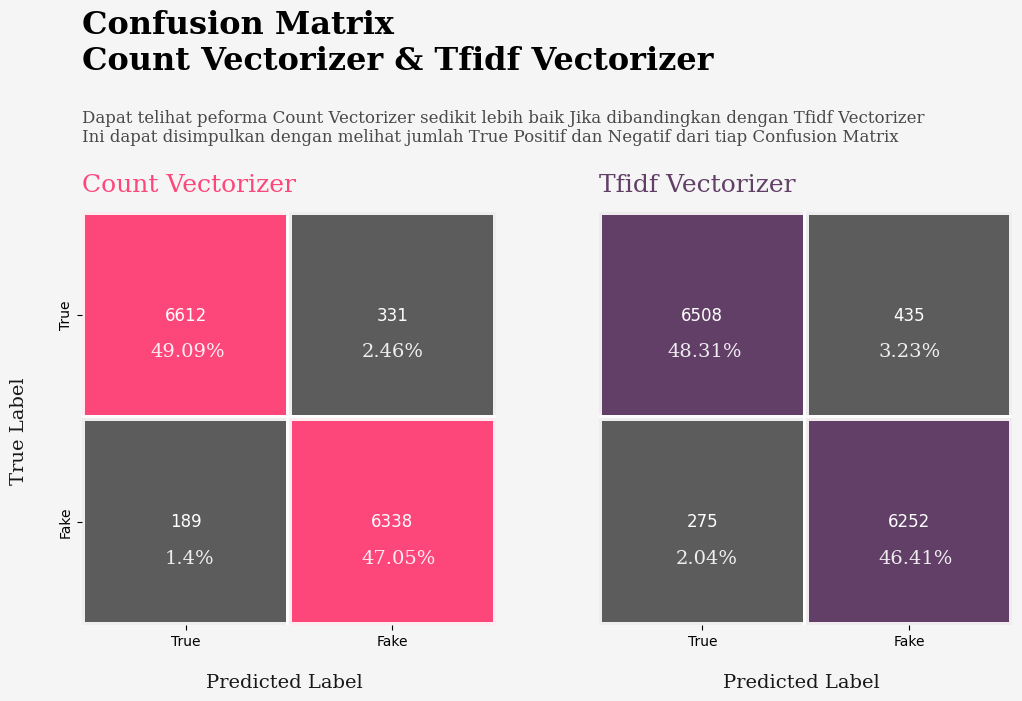

In [148]:
fig = plt.figure(figsize=(12,6),dpi = 100)
gs = fig.add_gridspec(1,2)
gs.update(wspace=0.25, hspace=0.5)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

fig.patch.set_facecolor('#f6f5f5')
ax0.set_facecolor('#f6f5f5')
ax1.set_facecolor('#f6f5f5')

col1 = ["#4b4b4c","#fe346e"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1, N = 256)
col2 = ["#4b4b4c","#512b58"]
colormap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", col2)

sns.heatmap(ax=ax0, data=conf_matrix_countvector, linewidths= 0,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=3, cmap = col1,annot=True, 
            annot_kws={"fontsize":12}, alpha = 0.9,fmt='')

sns.heatmap(ax=ax1, data=conf_matrix_tfidf, linewidths= 0,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=3, cmap = col2,annot=True, 
            annot_kws={"fontsize":12}, alpha = 0.9,fmt='')

ax0.text(0, -0.69, 'Confusion Matrix \nCount Vectorizer & Tfidf Vectorizer', {'font':'Serif', 'color':'black', 'weight':'bold','size':23})
ax0.text(0, -0.34, 'Dapat telihat peforma Count Vectorizer sedikit lebih baik Jika dibandingkan dengan Tfidf Vectorizer\nIni dapat disimpulkan dengan melihat jumlah True Positif dan Negatif dari tiap Confusion Matrix', {'font':'Serif', 'color':'black','size':12}, alpha = 0.7)


ax0.text(0,-0.1,'Count Vectorizer', {'font':'serif', 'color':"#fe346e", 'size':18},alpha = 0.9)
ax0.text(0.33,0.7,f'{round((conf_matrix_countvector[0][0] / len(X_test)) * 100,2)}%', {'font':'serif', 'color':"white", 'size':14},alpha = 0.9)
ax0.text(1.35,0.7,f'{round((conf_matrix_countvector[0][1] / len(X_test)) * 100,2)}%', {'font':'serif', 'color':"white", 'size':14},alpha = 0.9)
ax0.text(0.40,1.7,f'{round((conf_matrix_countvector[1][0] / len(X_test)) * 100,2)}%', {'font':'serif', 'color':"white", 'size':14},alpha = 0.9)
ax0.text(1.35,1.7,f'{round((conf_matrix_countvector[1][1] / len(X_test)) * 100,2)}%', {'font':'serif', 'color':"white", 'size':14},alpha = 0.9)


ax1.text(0,-0.1,'Tfidf Vectorizer', {'font':'serif', 'color':"#512b58", 'size':18}, alpha =0.9)
ax1.text(0.33,0.7,f'{round((conf_matrix_tfidf[0][0] / len(X_test)) * 100,2)}%', {'font':'serif', 'color':"white", 'size':14},alpha = 0.9)
ax1.text(1.35,0.7,f'{round((conf_matrix_tfidf[0][1] / len(X_test)) * 100,2)}%', {'font':'serif', 'color':"white", 'size':14},alpha = 0.9)
ax1.text(0.37,1.7,f'{round((conf_matrix_tfidf[1][0] / len(X_test)) * 100,2)}%', {'font':'serif', 'color':"white", 'size':14},alpha = 0.9)
ax1.text(1.35,1.7,f'{round((conf_matrix_tfidf[1][1] / len(X_test)) * 100,2)}%', {'font':'serif', 'color':"white", 'size':14},alpha = 0.9)



ax0.text(0.6,2.3,'Predicted Label', {'font':'serif', 'color':"black", 'size':14},alpha = 0.9)
ax0.text(-0.35,1.3,'True Label', {'font':'serif', 'color':"black", 'size':14},alpha = 0.9,rotation=90)
ax0.axes.set_xticklabels(['True', 'Fake'])
ax0.axes.set_yticklabels(['True', 'Fake'])

ax1.axes.set_xticklabels(['True', 'Fake'])
ax1.text(0.6,2.3,'Predicted Label', {'font':'serif', 'color':"black", 'size':14},alpha = 0.9)

ax0.set_xlabel('')
ax0.set_ylabel('')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.axes.get_yaxis().set_visible(False)
fig.show()